In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

In [4]:
import torchvision

## Loading MNIST Data
the `download=True` tag downloads the data if not available locally.

In [5]:
train_data = torchvision.datasets.MNIST("MNIST/raw/train-images-idx3-ubyte", train=True, download=True)
test_data = torchvision.datasets.MNIST("MNIST/raw/train-images-idx3-ubyte", train=False, download=True)

## Plotting MNIST Data

The MNIST images are `28x28` gray scale images. Each pixel value ranges between (0, 255). The dataset returns a tuple of PILLOW image object and the actual tag associated with the image. 

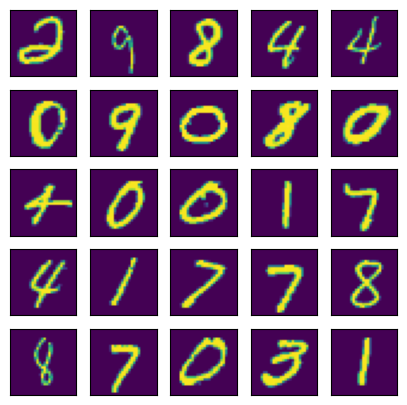

In [6]:
import numpy as np
import matplotlib.pyplot as plt 

image_size = 1
n_row, n_col = 5, 5
fig, axs = plt.subplots(n_row, n_col, sharex=True, sharey=True, figsize=(n_col*image_size, n_row*image_size))

rng = np.random.default_rng(seed=42)
data_instance = rng.choice(len(train_data), n_row * n_col, replace=False)

counter = 0
for i in range(n_row):
    for j in range(n_col):
        if n_row > 1:
            a = axs[i, j] if n_col > 1 else axs[i]
        else:
            a = axs[j] if n_col > 1 else axs
        a.imshow(train_data[data_instance[counter]][0])
        counter += 1
        a.set_xticks([])
        a.set_yticks([])
plt.show()

In [7]:
np.array(train_data[0][0]).shape

(28, 28)

## MNIST Variational AutoEncoder
This implementation includes a joint model, that produces a reconstruction along with classification

In [8]:
class MNISTVAEClassifier(nn.Module):
    def __init__(self, 
                 z_dim: int = 32,
                ):
        super(MNISTVAEClassifier, self).__init__()
        
        # encoder part
        self.conv1 = nn.Conv2d(1, 8, (3, 3))
        self.pool1 = nn.MaxPool2d((2, 2))
        self.conv2 = nn.Conv2d(8, 16, (3, 3))
        self.pool2 = nn.MaxPool2d((2, 2))
        self.flatten = nn.Flatten()  # 400
        self.fc31 = nn.Linear(400, z_dim)
        self.fc32 = nn.Linear(400, z_dim)
        
        # decoder part
        self.fc4 = nn.Linear(z_dim, 128)
        self.fc5 = nn.Linear(128, 128)
        self.fc6 = nn.Linear(128, 28 * 28)

        #classifier
        self.fc7 = nn.Linear(z_dim, 1)
        
    def encoder(self, x):
        h = self.pool1(F.relu(self.conv1(x)))
        h = self.pool2(F.relu(self.conv2(h)))
        h = self.flatten(h)
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h)).view(-1, 28, 28)

    def classify(self, z):
        return F.sigmoid(self.fc7(z)).reshape(-1)
    
    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var, self.classify(z)

### Custom loss function

The loss function consists of binary cross entropy for reconstruction error, KL divergence, and classification binary cross entropy loss. The training process converts the 28x28 input into a 28x28 matrix with value (0, 1), where 0 means background and 1 is a pixel part of the digit image. The loss function can be invoked only for the classification loss computation, reconstruction loss, or combined loss.

In [9]:
classification_wt = 100.

# return reconstruction error + KL divergence losses
def loss_function(recon_x: torch.Tensor, 
                  x: torch.Tensor, 
                  mu: torch.Tensor, 
                  log_var: torch.Tensor, 
                  y_p: torch.Tensor, 
                  y: torch.Tensor, 
                  with_classifier: bool,
                  with_reconstruction: bool):
    BCE = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    CLASSIFY = F.binary_cross_entropy(y_p, y)
    if with_classifier and with_reconstruction:
        return BCE + KLD + classification_wt * CLASSIFY
    elif with_reconstruction:
        return BCE + KLD
    else:
        return CLASSIFY

## Wrapper Dataset Object

Extends the dataset class or torch. Performs data normalization and also create the custom target value for classification task.

In [10]:
from torch.utils.data import DataLoader, Dataset

class WrapperDataset(Dataset):
    def __init__(self, 
                 mnist_dataset,
                ):
        self._data = mnist_dataset

    def __len__(self):
        return len(self._data)

    def __getitem__(self, item):
        x, y = self._data[item]
        y_e = y % 2
        x = torch.from_numpy(np.array(x)[np.newaxis, ...] / 256).float()
        y = torch.tensor(y).float()
        y_e = torch.tensor(y_e).float()
        return x, y, y_e

### Training
A subroutine that implements the training step.

def train(epoch: int, 
          vae_model: nn.Module,
          optimizer_: torch.optim.Optimizer,
          with_classify: bool,
          with_reconstruction: bool):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _, y) in enumerate(train_loader):
        data = data.to(device)
        y = y.to(device)
        optimizer_.zero_grad()
        
        recon_batch, mu, log_var, y_p = vae_model(data)
        loss = loss_function(recon_batch, 
                             data, 
                             mu, 
                             log_var, 
                             y_p, 
                             y, 
                             with_classify, 
                             with_reconstruction)
        
        loss.backward()
        train_loss += loss.item()
        optimizer_.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [11]:
def test(vae_model: nn.Module,
         with_classify: bool, 
         with_reconstruction: bool):
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _, y in test_loader:
            data = data.to(device)
            y = y.to(device)
            recon, mu, log_var, y_p = vae_model(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var, y_p, y, with_classify, with_reconstruction).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [12]:
def plot_reconstruction(vae_model: nn.Module,
                        n_sample: int = 5,
                        seed: int = 121,
                       ):
    rng = np.random.default_rng(seed=121)
    samples = rng.choice(len(test_dataset), n_sample, replace=False)

    sample_x = torch.stack([train_dataset[s][0] for s in samples], dim=0).float().to(device)
    recons_x = vae_model(sample_x)[0].cpu().detach().numpy() * 256
    sample_x = sample_x.cpu().detach().numpy()[:, 0]

    fig, axs = plt.subplots(2, n_sample, sharex=True, sharey=True, figsize=(n_sample*image_size, 2 * image_size))

    for i in range(n_sample):
        ax1, ax2 = (axs[0, i], axs[1, i]) if n_sample > 1 else (axs[0], axs[1])
        ax2.imshow(recons_x[i])
        ax1.imshow(sample_x[i])
        ax2.set_xticks([])
        ax2.set_yticks([])
        ax1.set_xticks([])
        ax1.set_yticks([])
    plt.show()

In [13]:
def get_embedding(vae_model):
    vae_model.eval()
    test_loss= 0
    emb, y, ye = [], [], []
    with torch.no_grad():
        for data, y_, ye_ in test_loader:
            data = data.to(device)
            result = vae_model(data)
            recons = result[0]
            mu = result[1]
            emb.append(mu.cpu().detach().numpy())
            y.append(y_.cpu().detach().numpy())
            ye.append(ye_.cpu().detach().numpy())
    return np.concatenate(emb, axis=0), np.concatenate(y, axis=0), np.concatenate(ye, axis=0)

In [14]:
def plot_test_embedding(vae_model: nn.Module,
                        dimension_reduction: str = 'pca',
                       ):
    emb, y_value, ye_value = get_embedding(vae_model)

    if dimension_reduction == 'pca':
        from sklearn.decomposition import PCA
        xe = PCA(n_components=2, svd_solver='full', random_state=42).fit_transform(emb)
    elif dimension_reduction == 'tsne':
        from sklearn.manifold import TSNE
        xe = TSNE(n_components=2, perplexity=embedding_dimension + 1, random_state=42).fit_transform(emb)
    else:
        from sklearn.manifold import Isomap
        xe = Isomap(n_components=2, n_neighbors=embedding_dimension + 1).fit_transform(emb)

    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    y_value = y_value.astype(int)
    ye_value = ye_value.astype(int)

    for i in range(10):
        index = y_value == i
        ax[0].scatter(xe[index, 0], xe[index, 1], label=f'{i}', s=5)

    for i in range(2):
        index = ye_value == i
        ax[1].scatter(xe[index, 0], xe[index, 1], label='even' if i == 0 else 'odd', s=5)

    for a in ax.flat:
        a.set_xticks([])
        a.set_yticks([])
        for s in ['top', 'left', 'right', 'bottom']:
            a.spines[s].set_visible(False)
    ax[0].legend(loc=(0.15, -0.1), ncol=5)
    ax[1].legend(loc=(0.3, -0.1), ncol=5)
    plt.show()

In [15]:
train_dataset = WrapperDataset(train_data)
test_dataset = WrapperDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
embedding_dimension = 32

In [17]:
vae = MNISTVAEClassifier(z_dim=embedding_dimension)
vae = vae.to(device)

In [18]:
optimizer_r = optim.Adam(vae.parameters())

for epoch in range(1, 21):
    train(epoch, vae, optimizer_r, with_classify=False, with_reconstruction=True)
    test(vae, with_classify=False, with_reconstruction=True)

Train Epoch: 1 [0/60000 (0%)]	Loss: 112.124672
Train Epoch: 1 [25600/60000 (43%)]	Loss: 115.245407
Train Epoch: 1 [51200/60000 (85%)]	Loss: 112.572678
====> Epoch: 1 Average loss: 112.2065
====> Test set loss: 111.1185
Train Epoch: 2 [0/60000 (0%)]	Loss: 112.459450
Train Epoch: 2 [25600/60000 (43%)]	Loss: 113.525894
Train Epoch: 2 [51200/60000 (85%)]	Loss: 110.293503
====> Epoch: 2 Average loss: 111.6798
====> Test set loss: 110.5577
Train Epoch: 3 [0/60000 (0%)]	Loss: 109.639503
Train Epoch: 3 [25600/60000 (43%)]	Loss: 106.734230
Train Epoch: 3 [51200/60000 (85%)]	Loss: 109.200653
====> Epoch: 3 Average loss: 111.2126
====> Test set loss: 110.4074
Train Epoch: 4 [0/60000 (0%)]	Loss: 112.044891
Train Epoch: 4 [25600/60000 (43%)]	Loss: 109.424149
Train Epoch: 4 [51200/60000 (85%)]	Loss: 109.989479
====> Epoch: 4 Average loss: 110.8518
====> Test set loss: 110.0943
Train Epoch: 5 [0/60000 (0%)]	Loss: 111.509010
Train Epoch: 5 [25600/60000 (43%)]	Loss: 110.453522
Train Epoch: 5 [51200/600

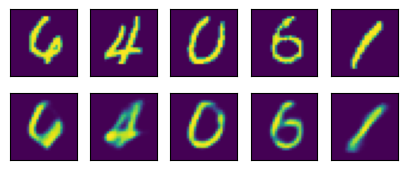

In [50]:
plot_reconstruction(vae)

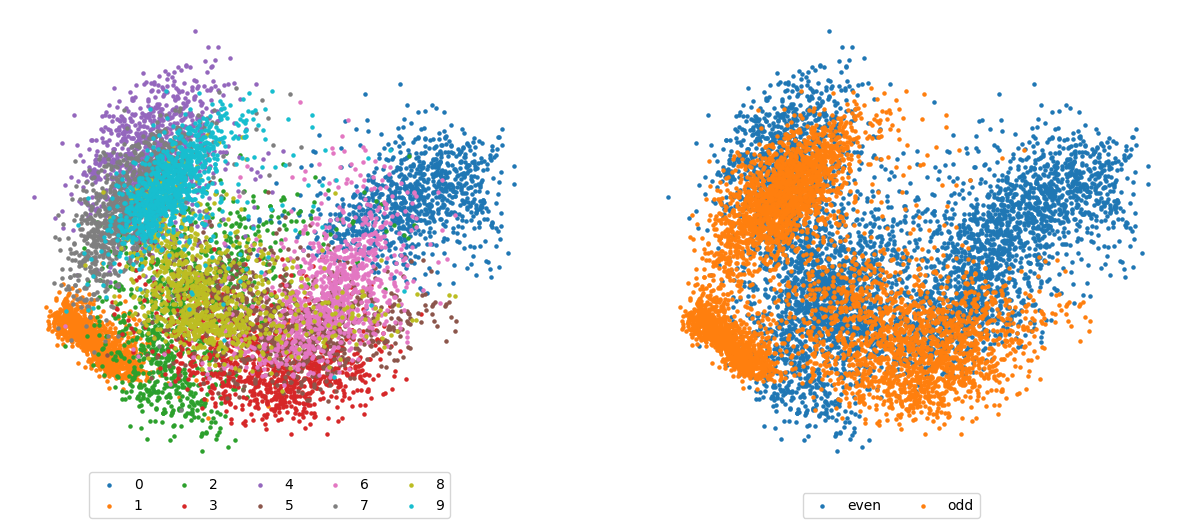

In [53]:
plot_test_embedding(vae_model=vae, dimension_reduction='isomap')

In [27]:
vae_classify = MNISTVAEClassifier(z_dim=embedding_dimension)
vae_classify = vae_classify.to(device)

In [32]:
optimizer_c = optim.Adam(vae_classify.parameters())

for epoch in range(1, 21):
    train(epoch, vae_classify, optimizer_c, with_classify=True, with_reconstruction=True)
    test(vae_classify, with_classify=True, with_reconstruction=True)

Train Epoch: 1 [0/60000 (0%)]	Loss: 545.062256
Train Epoch: 1 [25600/60000 (43%)]	Loss: 209.804581
Train Epoch: 1 [51200/60000 (85%)]	Loss: 194.883255
====> Epoch: 1 Average loss: 225.5236
====> Test set loss: 194.5277
Train Epoch: 2 [0/60000 (0%)]	Loss: 191.788986
Train Epoch: 2 [25600/60000 (43%)]	Loss: 190.500748
Train Epoch: 2 [51200/60000 (85%)]	Loss: 171.761185
====> Epoch: 2 Average loss: 182.7589
====> Test set loss: 166.3989
Train Epoch: 3 [0/60000 (0%)]	Loss: 168.834473
Train Epoch: 3 [25600/60000 (43%)]	Loss: 162.090012
Train Epoch: 3 [51200/60000 (85%)]	Loss: 153.760651
====> Epoch: 3 Average loss: 156.9235
====> Test set loss: 146.5198
Train Epoch: 4 [0/60000 (0%)]	Loss: 146.185211
Train Epoch: 4 [25600/60000 (43%)]	Loss: 142.551193
Train Epoch: 4 [51200/60000 (85%)]	Loss: 135.712921
====> Epoch: 4 Average loss: 141.2194
====> Test set loss: 135.5657
Train Epoch: 5 [0/60000 (0%)]	Loss: 135.194778
Train Epoch: 5 [25600/60000 (43%)]	Loss: 133.458389
Train Epoch: 5 [51200/600

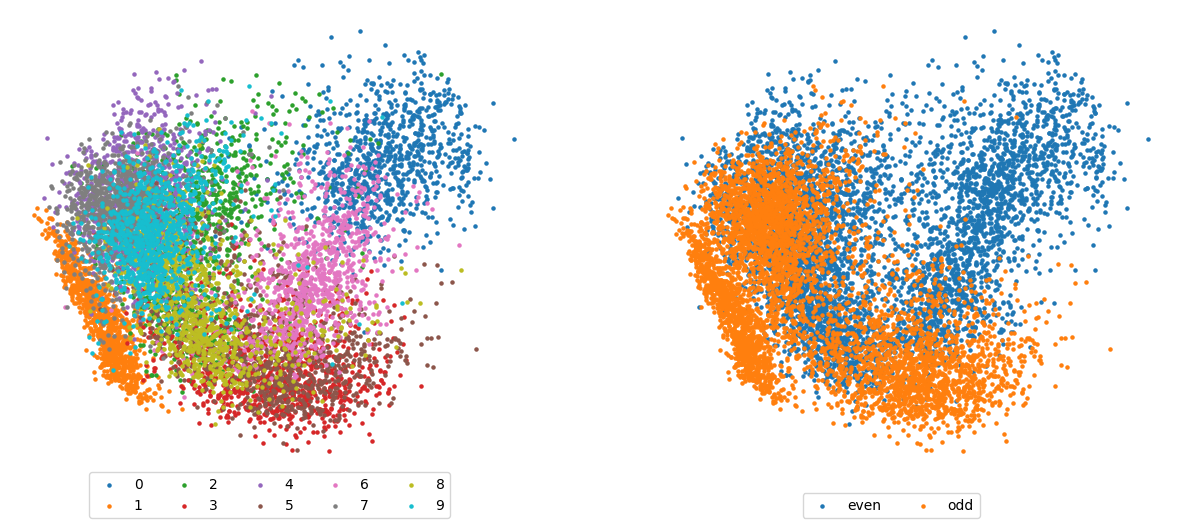

In [54]:
plot_test_embedding(vae_model=vae_classify, dimension_reduction='isomap')

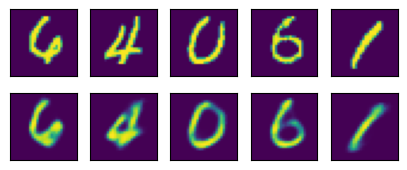

In [65]:
plot_reconstruction(vae_classify)

In [60]:
mnist_classify = MNISTVAEClassifier(z_dim=embedding_dimension)
mnist_classify = mnist_classify.to(device)

In [63]:
optimizer_m = optim.Adam(mnist_classify.parameters())

for epoch in range(1, 21):
    train(epoch, mnist_classify, optimizer_m, with_classify=True, with_reconstruction=False)
    test(mnist_classify, with_classify=True, with_reconstruction=False)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.002781
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.000953
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.000493
====> Epoch: 1 Average loss: 0.0012
====> Test set loss: 0.0006
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.000550
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.000416
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.000347
====> Epoch: 2 Average loss: 0.0004
====> Test set loss: 0.0003
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.000296
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.000206
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.000381
====> Epoch: 3 Average loss: 0.0003
====> Test set loss: 0.0003
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.000220
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.000232
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.000248
====> Epoch: 4 Average loss: 0.0003
====> Test set loss: 0.0003
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.000237
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.000214
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.000192
====> Epoch: 5 Aver

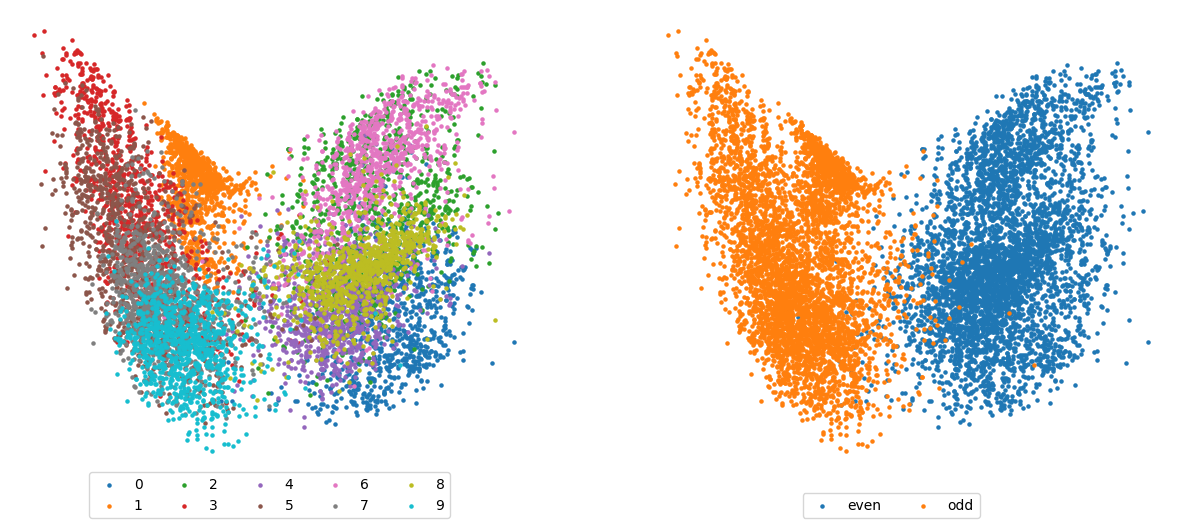

In [64]:
plot_test_embedding(vae_model=mnist_classify, dimension_reduction='isomap')

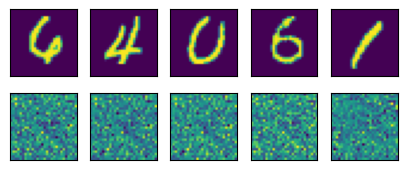

In [66]:
plot_reconstruction(mnist_classify)